In [185]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# EDA

In [186]:
#Importing dataset
df_INR = pd.read_csv("CUR-INR.csv")

In [187]:
df_INR.head()

,DATE,RATE
0,2016-12-31,67.9669
1,2016-12-30,67.9728
2,2016-12-29,67.9450
3,2016-12-28,68.2289
4,2016-12-27,67.9965


In [188]:
df_INR.columns

Index(['DATE', 'RATE'], dtype='object')

In [189]:
df_INR.dtypes

DATE     object
RATE    float64
dtype: object

In [190]:
# converting date to datetime64[ns] type
df_INR['DATE'] = pd.to_datetime(df_INR['DATE'], format='%Y-%m-%d', dayfirst=True)

In [191]:
#Find the duplicates
df_INR.duplicated().sum()

0

In [192]:
# We can get date month and year part from the date column
df_INR['month'] = df_INR['DATE'].dt.month
df_INR['year'] = df_INR['DATE'].dt.year
df_INR['day'] = df_INR['DATE'].dt.day
df_INR['day_of_week'] = df_INR['DATE'].dt.weekday

In [193]:
df_INR.head()

,DATE,RATE,month,year,day,day_of_week
0,2016-12-31,67.9669,12,2016,31,5
1,2016-12-30,67.9728,12,2016,30,4
2,2016-12-29,67.9450,12,2016,29,3
3,2016-12-28,68.2289,12,2016,28,2
4,2016-12-27,67.9965,12,2016,27,1


In [194]:
#Find the duplicates
df_INR.duplicated().sum()

0

In [195]:
df_INR.shape

(6208, 6)

# Chaos Test - Will be adding later

# ADF Test

In [196]:
# check for Stationarity - ADF Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_INR['RATE'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.1314537133705005
p-value: 0.2320563938031484
Critial Values:
   1%, -3.4314055034463933
Critial Values:
   5%, -2.8620064382326373
Critial Values:
   10%, -2.5670182822217993


In [197]:
"""
From ADF test, it's observed that, data is not stationary. 
We can see p-value is 23% (usually it must be less than 0.05 or 5%), 
and ADF-stat value is greater than all the critical values. 

Both these values confirms the data to be Non-Stationary
"""

"\nFrom ADF test, it's observed that, data is not stationary. \nWe can see p-value is 23% (usually it must be less than 0.05 or 5%), \nand ADF-stat value is greater than all the critical values. \n\nBoth these values confirms the data to be Non-Stationary\n"

# Splitting the dataset

In [198]:
X = df_INR.iloc[:, 2:].values
y = df_INR.iloc[:, 1].values

In [199]:
X.shape

(6208, 4)

In [200]:
y.shape

(6208,)

In [201]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [202]:
# SMAPE function - Symmetric mean absolute percentage error
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [203]:
# Direction Symmetry - It gives the percentage of occurrences in which the sign of the change in value from one time period to the next is the same for both the actual and predicted time series
def ds(A, F):
    sum_A = 0
    for i in range(1, len(A)):
        sum_A += 1 if (A[i]-A[i-1])*(F[i]-F[i-1])>0 else 0
    return (100*sum_A)/(len(A)-1)

In [204]:
# Theil's U coefficient - The greater accuracy of the forecast, the lower will be the value of the u1
def u1(A,F):
    data = pd.DataFrame({'A_i':A, 'F_i': F})
    data['(A_i - F_i)^2'] = np.square(data['A_i'] - data['F_i'])
    data['F_i^2'] = np.square(data['F_i'])
    data['A_i^2'] = np.square(data['A_i'])
    return (np.sqrt(np.mean(data['(A_i - F_i)^2'])))/(np.sqrt(np.mean(data['F_i^2']))+np.sqrt(np.mean(data['A_i^2'])))

# Linear Regression

In [205]:
# Fitting Linear Regression in dataset
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [206]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.5330657344898648
MSE 27.712855764017704
RMSE 5.264300121005422


 SMAPE prediction

In [207]:
print(smape(y_test, y_pred))

9.123216652331552


 Direction Symmetry prediction

In [208]:
print(ds(y_test, y_pred))

69.95486782720825


 Theil's U coefficient prediction

In [209]:
print(u1(y_test, y_pred))

0.05208165957262899


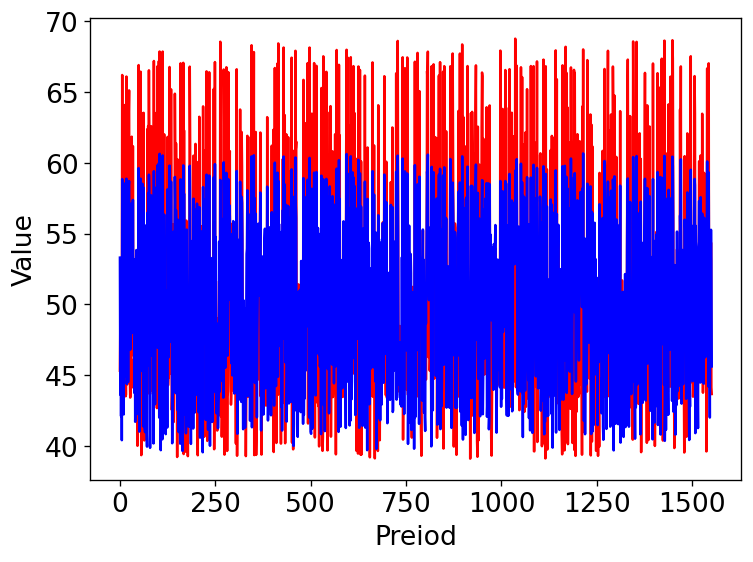

In [210]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# Polynomial Regression

In [211]:
# Fitting Polynomial Regression in dataset
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_trans = poly.fit_transform(X_train)
X_test_trans = poly.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_trans, y_train)
y_pred = lr.predict(X_test_trans)

In [212]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.8764786886536248
MSE 7.331071069253361
RMSE 2.7075950711384746


 SMAPE prediction

In [213]:
print(smape(y_test, y_pred))

4.467257747537943


 Direction Symmetry prediction

In [214]:
print(ds(y_test, y_pred))

76.9825918762089


 Theil's U coefficient prediction

In [215]:
print(u1(y_test, y_pred))

0.02678374817901118


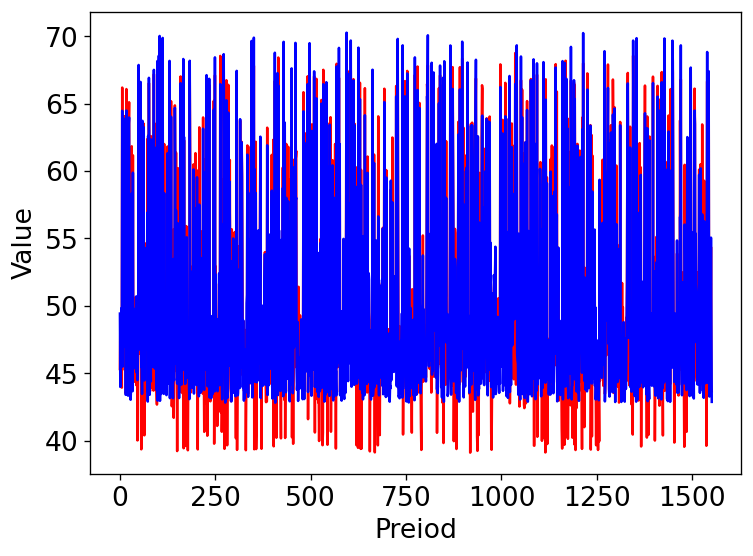

In [216]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# Decision Tree Regression

In [217]:
# Fitting Decision Tree Regression in dataset
from sklearn.tree import DecisionTreeRegressor 

regressor = DecisionTreeRegressor(random_state = 0) 

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [218]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.9989301949299728
MSE 0.06349363452452458
RMSE 0.25197943274109613


 SMAPE prediction

In [219]:
print(smape(y_test, y_pred))

0.2517210120494599


 Direction Symmetry prediction

In [220]:
print(ds(y_test, y_pred))

98.58156028368795


 Theil's U coefficient prediction

In [221]:
print(u1(y_test, y_pred))

0.0024902207758533707


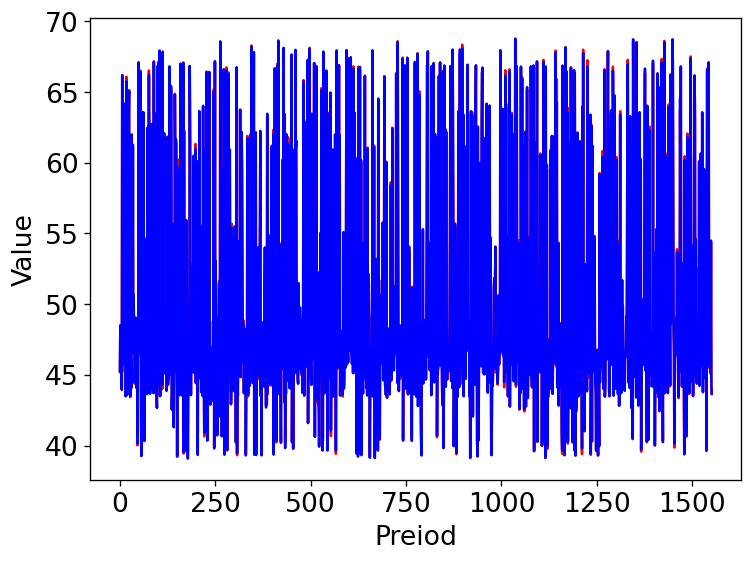

In [222]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

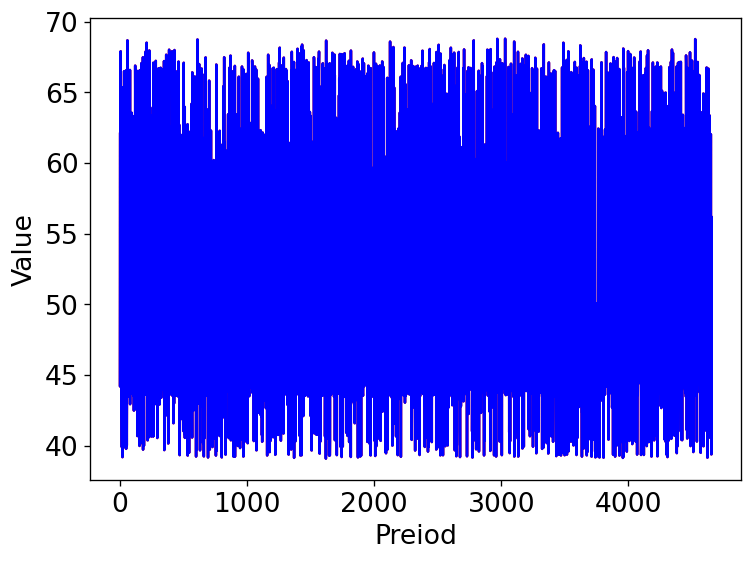

In [223]:
# It is overfitted
plt.rc("figure")
plt.plot(y_train, color="r")
plt.plot(regressor.predict(X_train), color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# Random Forest Regression

In [224]:
from sklearn.ensemble import RandomForestRegressor

In [225]:
model = RandomForestRegressor()

In [226]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": [3, 4],
              "n_estimators": [100, 300, 1000]}

# try out every combination of the above values
search = GridSearchCV(model, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'max_depth': 4, 'n_estimators': 100}


In [227]:
# Fitting Random Forest Regression in dataset
regressor = RandomForestRegressor(n_estimators  = search.best_params_["n_estimators"],
                                   max_depth     = search.best_params_["max_depth"])

regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test)

In [228]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.9442693646445659
MSE 3.307649862780711
RMSE 1.8186945490600424


 SMAPE prediction

In [229]:
print(smape(y_test, y_pred))

2.8574512558559535


 Direction Symmetry prediction

In [230]:
print(ds(y_test, y_pred))

81.43133462282398


 Theil's U coefficient prediction

In [231]:
print(u1(y_test, y_pred))

0.017988143392855916


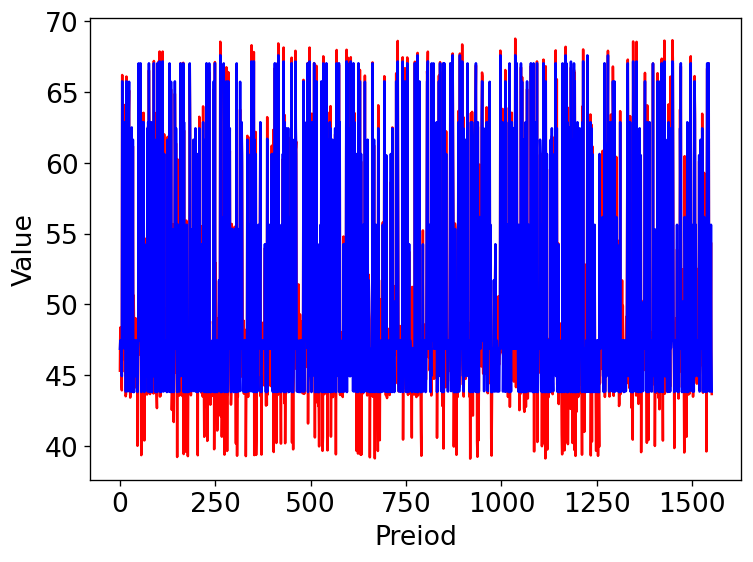

In [232]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

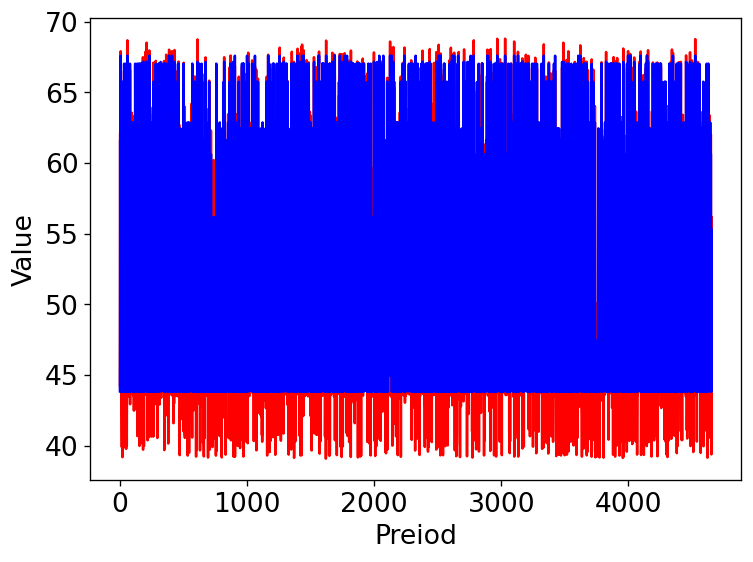

In [233]:
# It is not overfitted
plt.rc("figure")
plt.plot(y_train, color="r")
plt.plot(regressor.predict(X_train), color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# XGB Regression

In [234]:
from xgboost import XGBRegressor

In [235]:
model = XGBRegressor()

In [236]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
              "n_estimators": [100, 300, 1000],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(model, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 10, 'n_estimators': 1000}


In [237]:
regressor = XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [238]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.9991549044662271
MSE 0.05015697575477248
RMSE 0.22395753114100111


 SMAPE prediction

In [239]:
print(smape(y_test, y_pred))

0.2907289051343306


 Direction Symmetry prediction

In [240]:
print(ds(y_test, y_pred))

98.45261121856866


 Theil's U coefficient prediction

In [241]:
print(u1(y_test, y_pred))

0.002213450945194884


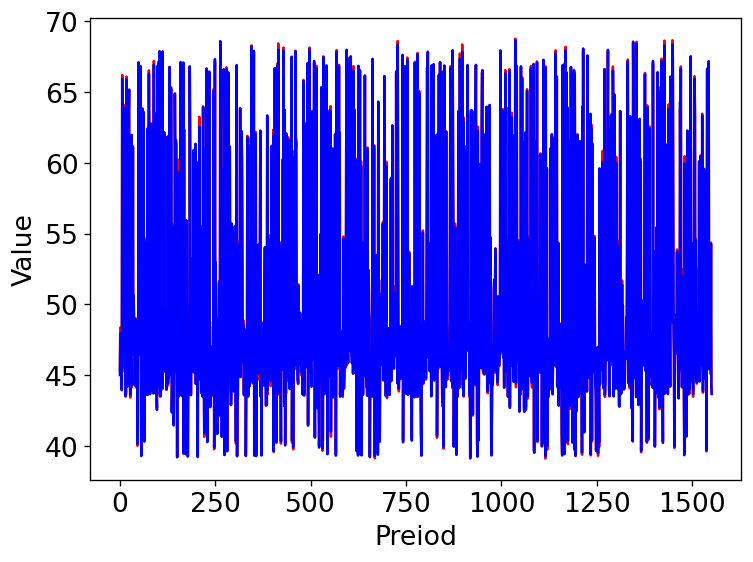

In [242]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# SGD Regression

In [243]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [244]:
from sklearn.pipeline import Pipeline

# Create a Pipeline object
sgd_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('sgd', SGDRegressor()),
    ])

# Create a dictionary object with hyperparameters as keys and lists of corresponding values
param_grid = {'sgd__alpha': [0.5, 0.3, 0.2, 0.1, 0.01, 0.001, 0.0001], 
              'sgd__l1_ratio': np.arange(0, 1.1, 0.1), 
              'sgd__max_iter':[100, 200, 500, 1000],
              'sgd__eta0': [0.01, 0.001, 0.0001],
              'sgd__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
              'sgd__warm_start': [True, False]
            }

# Create a GridSearchCV object and perform hyperparameter tuning
sgdr = GridSearchCV(sgd_pipeline, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# The model is trained with optimal hyperparameters, thus its the optimal model
sgdr.fit(X_train, y_train)

# Get the optimal hyperparameters
params_optimal_sgdr = sgdr.best_params_

print("Best Score (negative mean squared error): %f" % sgdr.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sgdr)

Fitting 3 folds for each of 7392 candidates, totalling 22176 fits
Best Score (negative mean squared error): -27.442188
Optimal Hyperparameter Values:  {'sgd__alpha': 0.01, 'sgd__eta0': 0.01, 'sgd__l1_ratio': 1.0, 'sgd__learning_rate': 'optimal', 'sgd__max_iter': 1000, 'sgd__warm_start': False}


In [245]:
y_pred = sgdr.predict(X_test)

In [246]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.5325882413369705
MSE 27.741195296692634
RMSE 5.266991104671873


 SMAPE prediction

In [247]:
print(smape(y_test, y_pred))

9.119440331771573


 Direction Symmetry prediction

In [248]:
print(ds(y_test, y_pred))

69.6969696969697


 Theil's U coefficient prediction

In [249]:
print(u1(y_test, y_pred))

0.052136038440223444


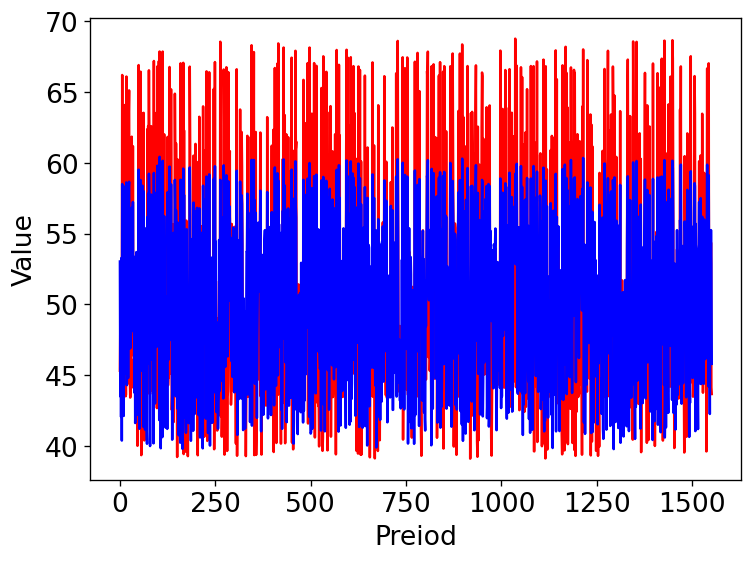

In [250]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# LSTM

In [251]:
# Splitting the dataset into the Training set and Test set
X = df_INR.iloc[:, 2:].values
y = df_INR.iloc[:, 1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [252]:
# Feature scaling
from sklearn.preprocessing import MinMaxScaler

sc_X = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = MinMaxScaler()
y_train = sc_y.fit_transform(y_train.reshape(-1,1))

In [253]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [254]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(1, 4)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 100)            42000     
                                                                 
 dense_4 (Dense)             (None, 1, 1)              101       
                                                                 
Total params: 42,101
Trainable params: 42,101
Non-trainable params: 0
_________________________________________________________________


In [255]:
# fit model
X_train = np.reshape(X_train, (X_train.shape[0], 1, 4))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 4))
history = model.fit(X_train, y_train, epochs=5, batch_size=1, verbose=1, validation_split=0.1)

Epoch 1/5
4190/4190 [==============================] - 24s 5ms/step - loss: 0.0201 - val_loss: 0.0080
Epoch 2/5
4190/4190 [==============================] - 18s 4ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 3/5
4190/4190 [==============================] - 19s 4ms/step - loss: 0.0057 - val_loss: 0.0061
Epoch 4/5
4190/4190 [==============================] - 19s 4ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 5/5
4190/4190 [==============================] - 19s 5ms/step - loss: 0.0054 - val_loss: 0.0050


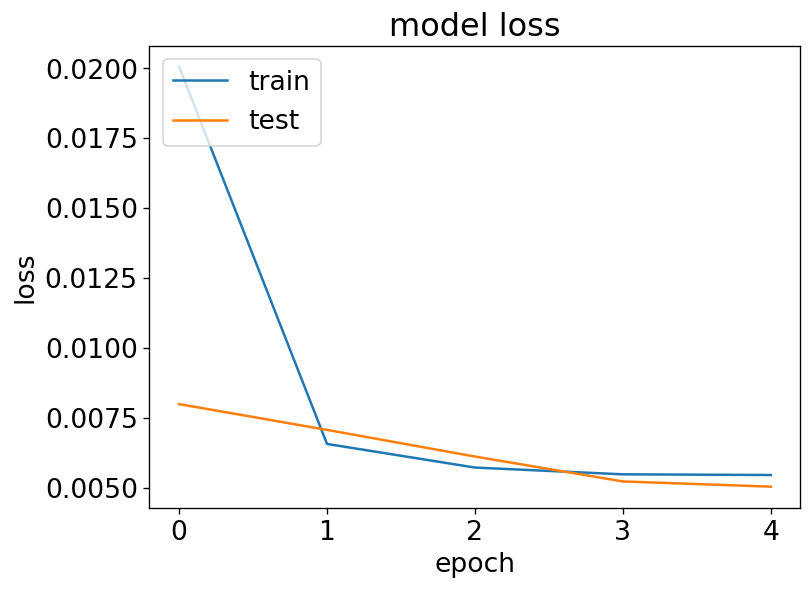

In [256]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [257]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
test_predict = sc_y.inverse_transform(test_predict.reshape(-1,1))

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

49/49 [==============================] - 0s 4ms/step
Shape of train and test predict:  (4656, 1, 1) (1552, 1)


In [258]:
# root mean squared error or rmse
import math
from sklearn.metrics import mean_squared_error

def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

train_score = measure_rmse(y_train, train_predict.reshape(-1,1))
test_score = measure_rmse(y_test, test_predict)

print('Train and Test RMSE: ', train_score, test_score)

Train and Test RMSE:  0.06912772677120696 2.07690197925109


In [259]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.5325882413369705
MSE 27.741195296692634
RMSE 5.266991104671873


 SMAPE prediction

In [260]:
print(smape(y_test, y_pred))

9.119440331771573


 Direction Symmetry prediction

In [261]:
print(ds(y_test, y_pred))

69.6969696969697


 Theil's U coefficient prediction

In [262]:
print(u1(y_test, y_pred))

0.052136038440223444


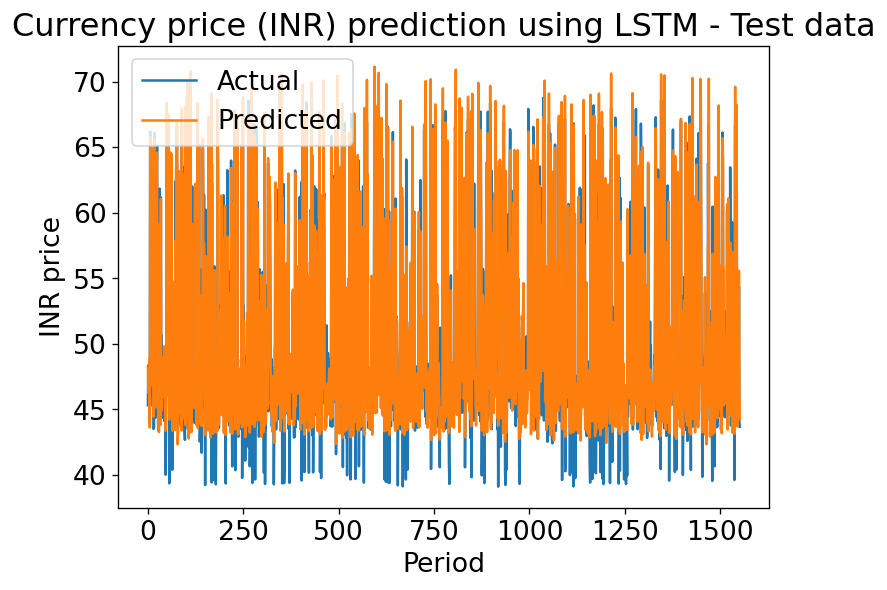

In [263]:
plt.rc("figure")
plt.rcParams.update({'font.size': 16})
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.xlabel('Period')
plt.ylabel('INR price')
plt.title('Currency price (INR) prediction using LSTM - Test data')
plt.legend()
plt.show()

# ANN 1-10-1

In [264]:
# Splitting the dataset
X = df_INR.iloc[:, 0].values
y = df_INR.iloc[:, 1].values

In [265]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [266]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train.reshape(-1,1))
X_test = sc_X.transform(X_test.reshape(-1,1))

sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.reshape(-1,1))

In [267]:
from keras.models import Sequential
from keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(10, activation = 'relu', input_dim = 1))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 10)                20        
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [268]:
# fit model
history = model.fit(X_train, y_train, epochs=25, batch_size=10, verbose=1, validation_split=0.1)

Epoch 1/25
419/419 [==============================] - 3s 4ms/step - loss: 0.8572 - val_loss: 0.6458
Epoch 2/25
419/419 [==============================] - 1s 3ms/step - loss: 0.6004 - val_loss: 0.5151
Epoch 3/25
419/419 [==============================] - 1s 3ms/step - loss: 0.5187 - val_loss: 0.4716
Epoch 4/25
419/419 [==============================] - 1s 4ms/step - loss: 0.4900 - val_loss: 0.4559
Epoch 5/25
419/419 [==============================] - 2s 4ms/step - loss: 0.4787 - val_loss: 0.4486
Epoch 6/25
419/419 [==============================] - 2s 4ms/step - loss: 0.4728 - val_loss: 0.4444
Epoch 7/25
419/419 [==============================] - 1s 3ms/step - loss: 0.4692 - val_loss: 0.4422
Epoch 8/25
419/419 [==============================] - 1s 4ms/step - loss: 0.4670 - val_loss: 0.4400
Epoch 9/25
419/419 [==============================] - 2s 4ms/step - loss: 0.4654 - val_loss: 0.4389
Epoch 10/25
419/419 [==============================] - 2s 4ms/step - loss: 0.4644 - val_loss: 0.4381

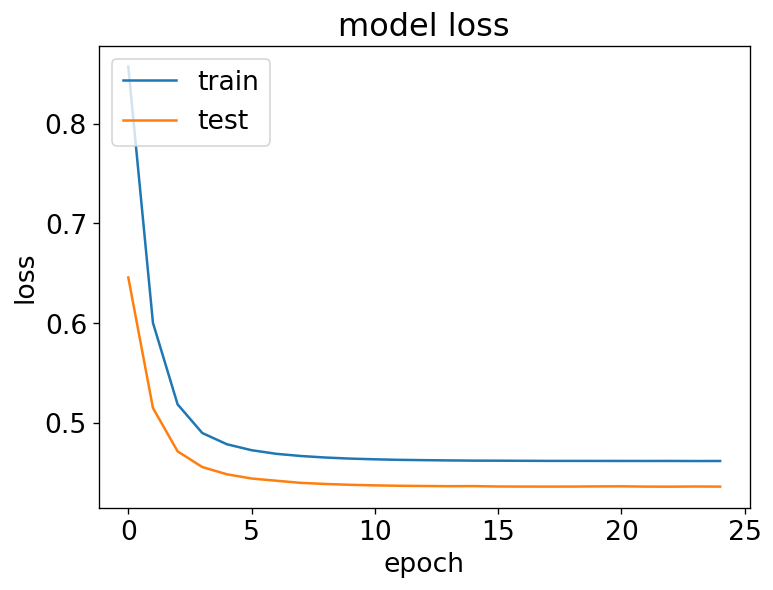

In [269]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [270]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
test_predict = sc_y.inverse_transform(test_predict.reshape(-1,1))

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

49/49 [==============================] - 0s 3ms/step
Shape of train and test predict:  (4656, 1) (1552, 1)


In [271]:
# root mean squared error or rmse
import math
from sklearn.metrics import mean_squared_error

def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

train_score = measure_rmse(y_train, train_predict)
test_score = measure_rmse(y_test, test_predict)

print('Train and Test RMSE: ', train_score, test_score)

Train and Test RMSE:  0.6777262674799008 5.260403664792187


In [272]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, test_predict))
print("MSE", mean_squared_error(y_test, test_predict))
print("RMSE", math.sqrt(mean_squared_error(y_test, test_predict)))

R2 score:  0.5325882413369705
MSE 27.741195296692634
RMSE 5.266991104671873


 SMAPE prediction

In [273]:
print(smape(y_test, test_predict))

9.119440331771573


 Direction Symmetry prediction

In [274]:
print(ds(y_test, test_predict))

69.6969696969697


 Theil's U coefficient prediction

In [275]:
print(u1(y_test, test_predict))

0.052136038440223444


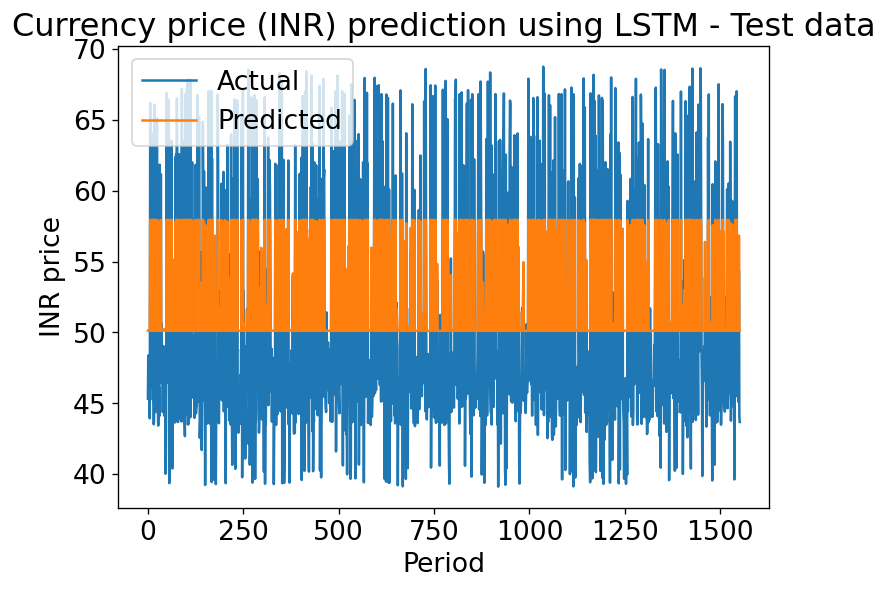

In [276]:
plt.rc("figure")
plt.rcParams.update({'font.size': 16})
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.xlabel('Period')
plt.ylabel('INR price')
plt.title('Currency price (INR) prediction using LSTM - Test data')
plt.legend()
plt.show()

# SARIMA

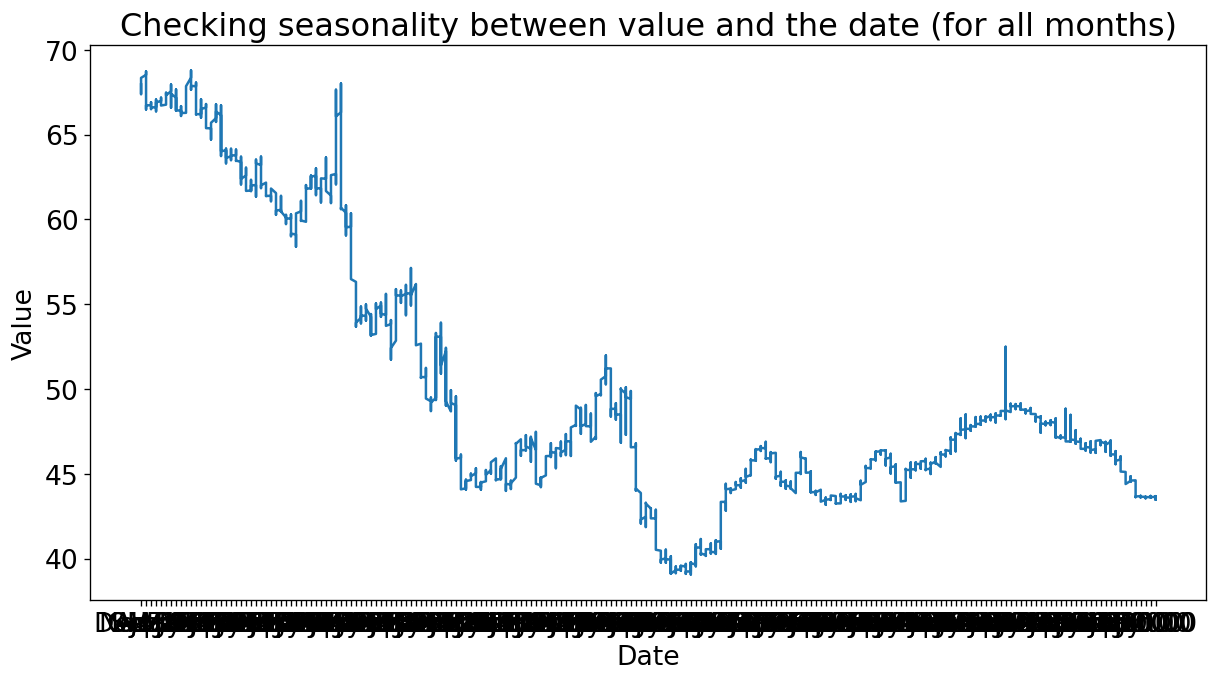

In [278]:
# Analysing for seasonality
from datetime import datetime
INR_dataset = pd.read_csv("CUR-INR.csv")
Date_column = [datetime.strptime(d, '%Y-%m-%d').strftime("%b %y") for d in INR_dataset['DATE']]
Day_column = [datetime.strptime(d, '%Y-%m-%d').strftime("%A") for d in INR_dataset['DATE']]

# Let's check for all the months for the exchange rate currency values in india
plt.figure(figsize=(12,6))
plt.plot(Date_column, INR_dataset['RATE'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for all months)')
plt.show()

The graph is neither increasing or decreasing based on the months. So, let's check it for a particular week.

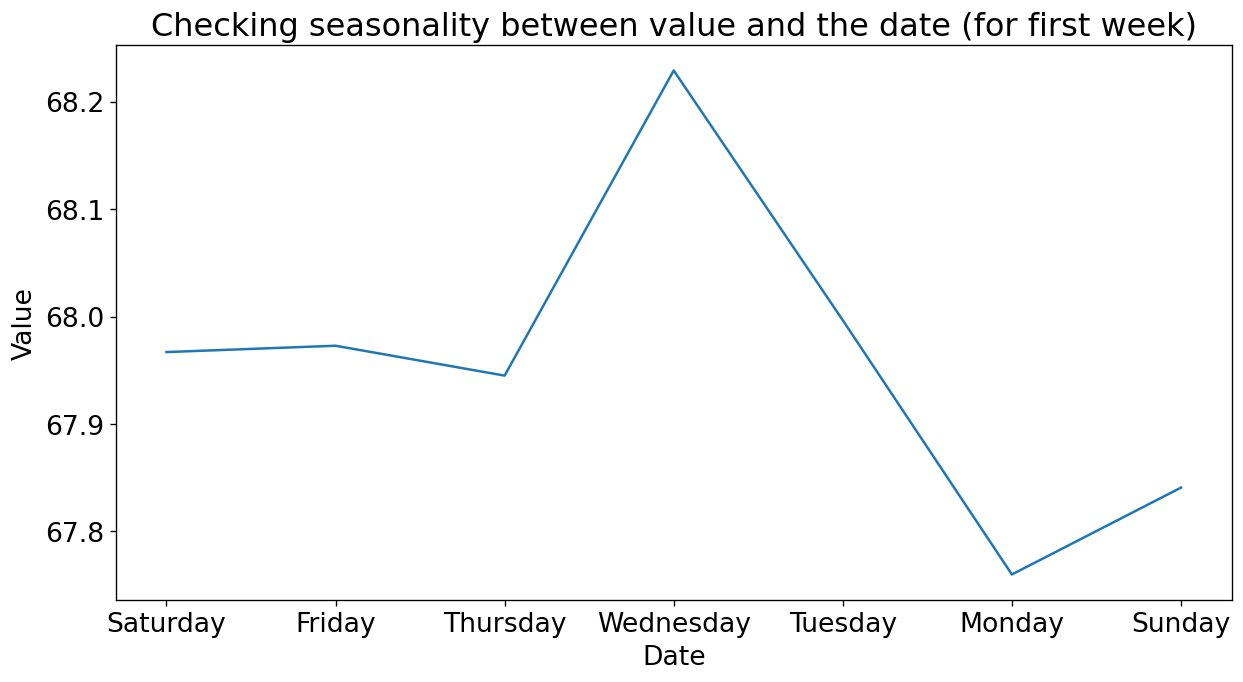

In [279]:
plt.figure(figsize=(12,6))
plt.plot(Day_column[:7], INR_dataset['RATE'][:7])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for first week)')
plt.show()

In week we get to see that the friday has the highest currency rate and it decreases as we move to weekends. So, let's check for multiple weeks and figure out about the days at which we get the higher currency rate from all the week days.

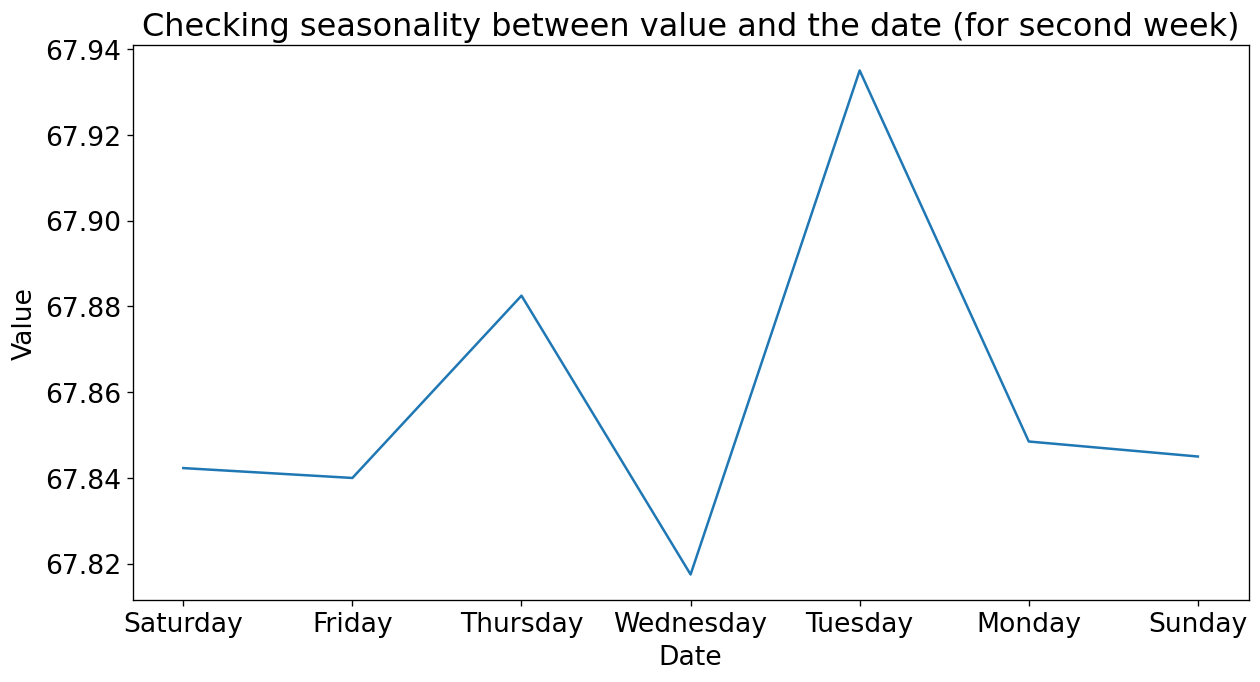

In [280]:
plt.figure(figsize=(12,6))
plt.plot(Day_column[7:14], INR_dataset['RATE'][7:14])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for second week)')
plt.show()

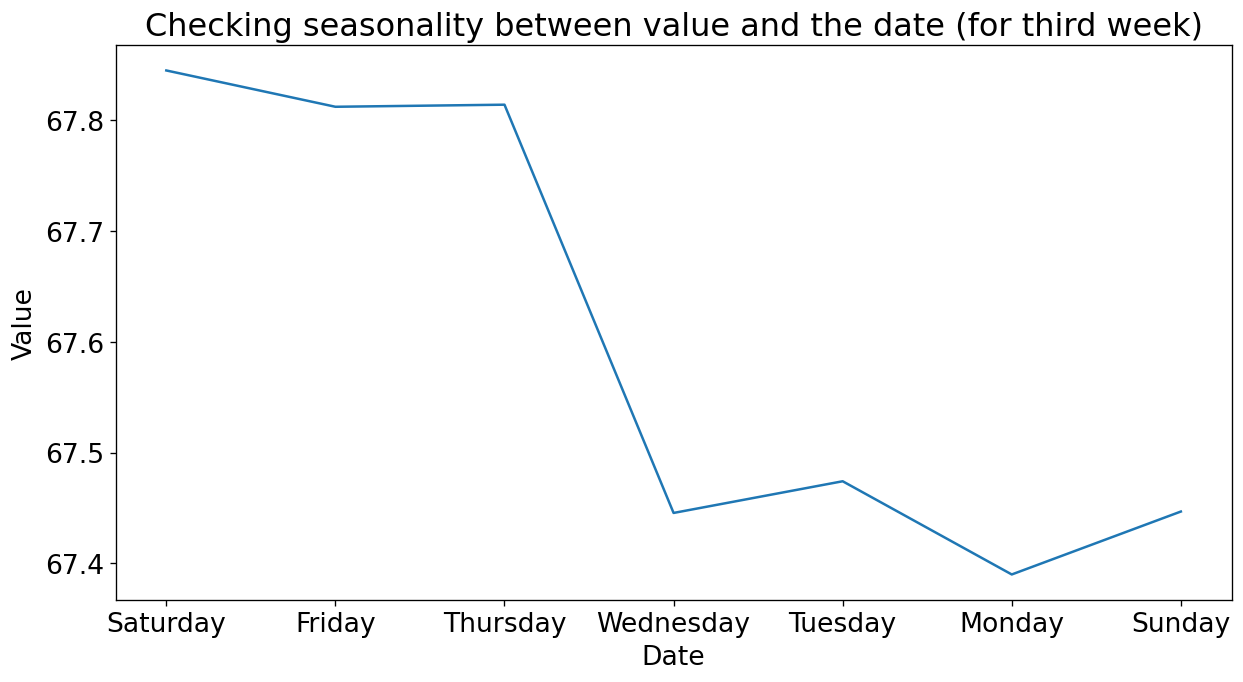

In [281]:
plt.figure(figsize=(12,6))
plt.plot(Day_column[14:21], INR_dataset['RATE'][14:21])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for third week)')
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, '2016-12-31'),
  Text(1, 0, '2016-12-30'),
  Text(2, 0, '2016-12-29'),
  Text(3, 0, '2016-12-28'),
  Text(4, 0, '2016-12-27'),
  Text(5, 0, '2016-12-26'),
  Text(6, 0, '2016-12-25'),
  Text(7, 0, '2016-12-24'),
  Text(8, 0, '2016-12-23'),
  Text(9, 0, '2016-12-22'),
  Text(10, 0, '2016-12-21'),
  Text(11, 0, '2016-12-20'),
  Text(12, 0, '2016-12-19'),
  Text(13, 0, '2016-12-18'),
  Text(14, 0, '2016-12-17'),
  Text(15, 0, '2016-12-16'),
  Text(16, 0, '2016-12-15'),
  Text(17, 0, '2016-12-14'),
  Text(18, 0, '2016-12-13'),
  Text(19, 0, '2016-12-12'),
  Text(20, 0, '2016-12-11')])

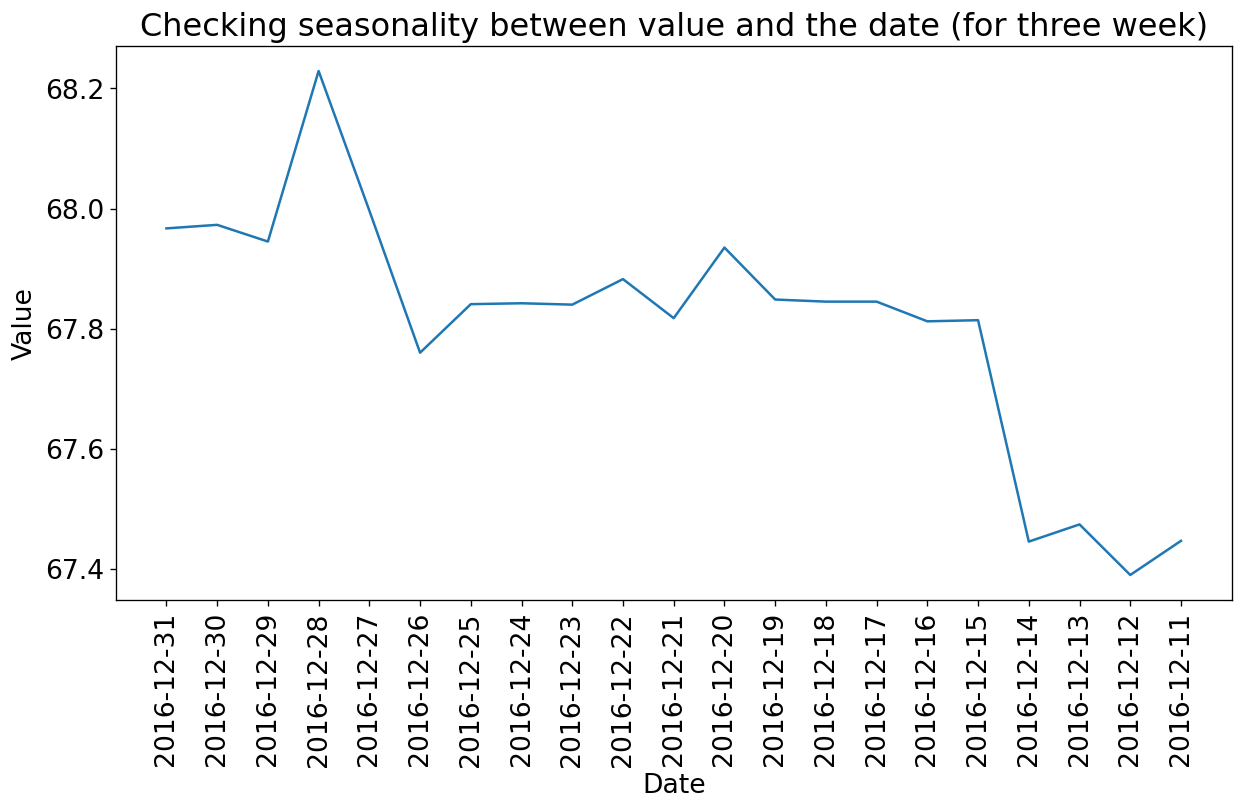

In [282]:
plt.figure(figsize=(12,6))
plt.plot(INR_dataset['DATE'][:21], INR_dataset['RATE'][:21])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for three week)')
plt.xticks(rotation=90)

As, we can see in the graph the rate of currency increases highly when we move from the december 31st, 2021 to January 1st 2022 and same when we have festivals like the currency rate rapidly increased when we have christmas on 25th or 26th december. 
Hence, SARIMA can help us to predict ouput currency rate based on the seasonality. 

In [283]:
INR_dataset = INR_dataset.set_index('DATE')

In [284]:
INR_dataset.dtypes

RATE    float64
dtype: object

In [285]:
INR_dataset = INR_dataset.iloc[:, :]
INR_dataset.head()

,RATE
DATE,
2016-12-31,67.9669
2016-12-30,67.9728
2016-12-29,67.9450
2016-12-28,68.2289
2016-12-27,67.9965


We have to calculate p, d, q, P, D, and Q value for the SARIMA to make the model for our forecasting

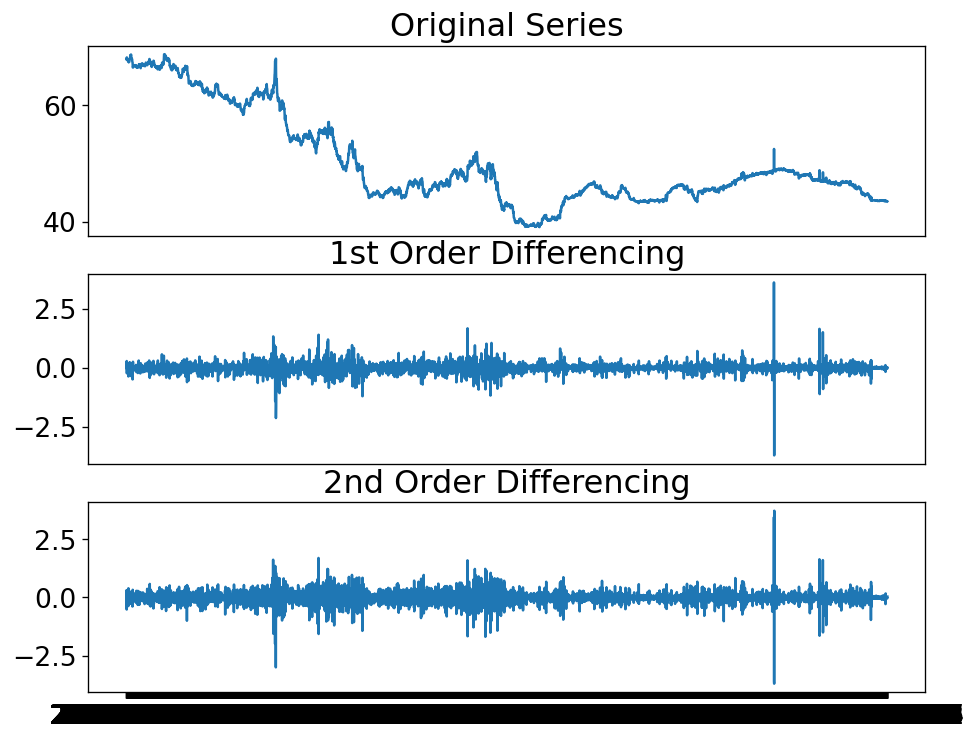

In [286]:
# Finding the d value
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(INR_dataset.RATE); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(INR_dataset.RATE.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(INR_dataset.RATE.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

In the first order differencing we have few noises than the second order differencing. So, we select the first order differencing for the model

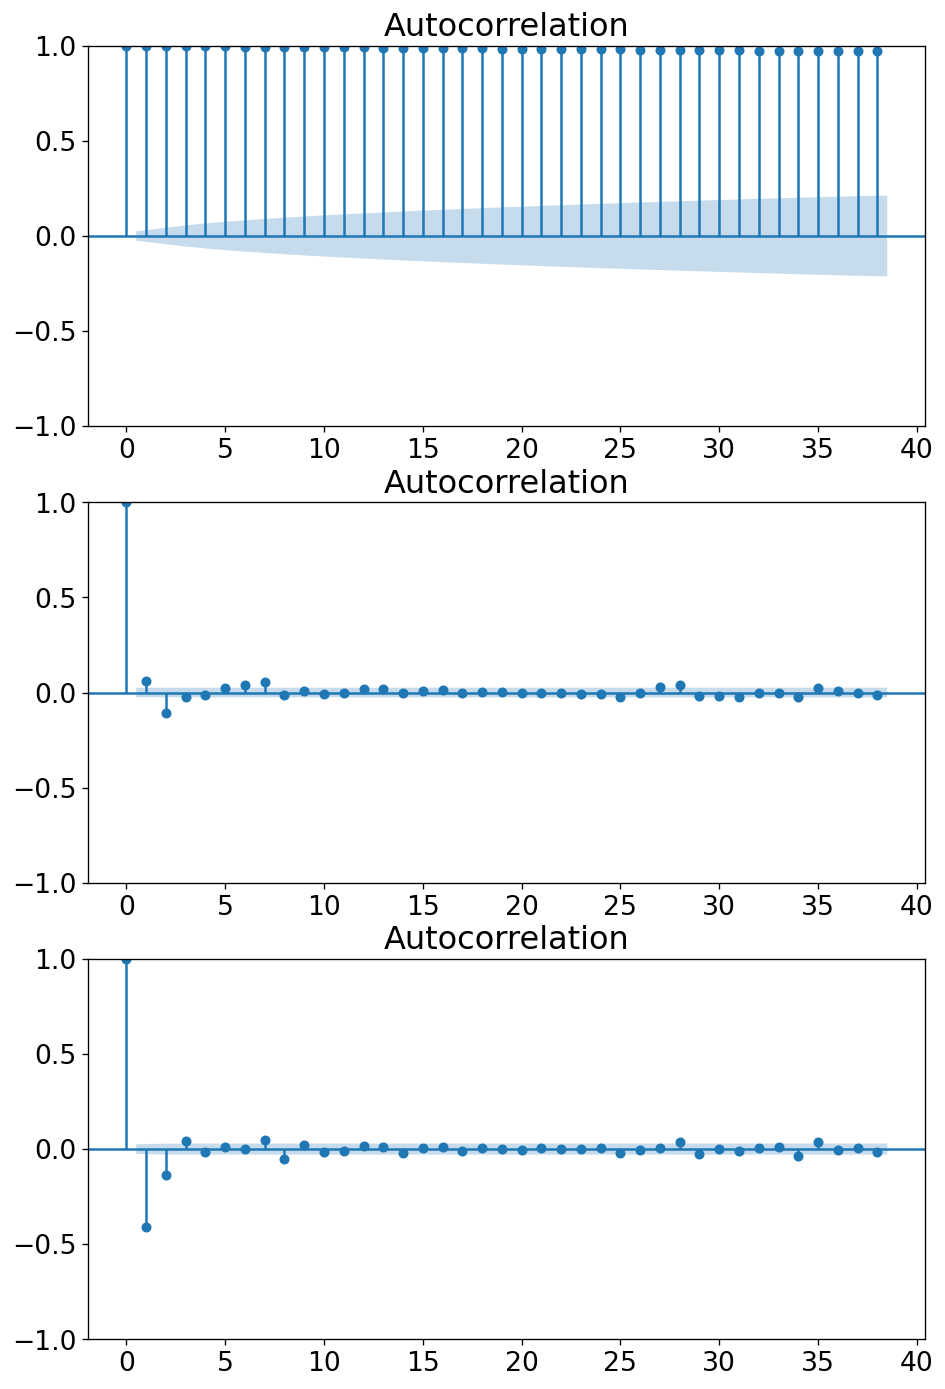

In [287]:
from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams.update({'figure.figsize':(9,14), 'figure.dpi':120})
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(INR_dataset.RATE, ax=ax1)
plot_acf(INR_dataset.RATE.diff().dropna(), ax=ax2)
plot_acf(INR_dataset.RATE.diff().diff().dropna(), ax=ax3)
plt.show()

Here we can see that the second order differencing the immediate lag is gone to the negative side, representing that in second order the series has become over the difference.
Hence d = 1.

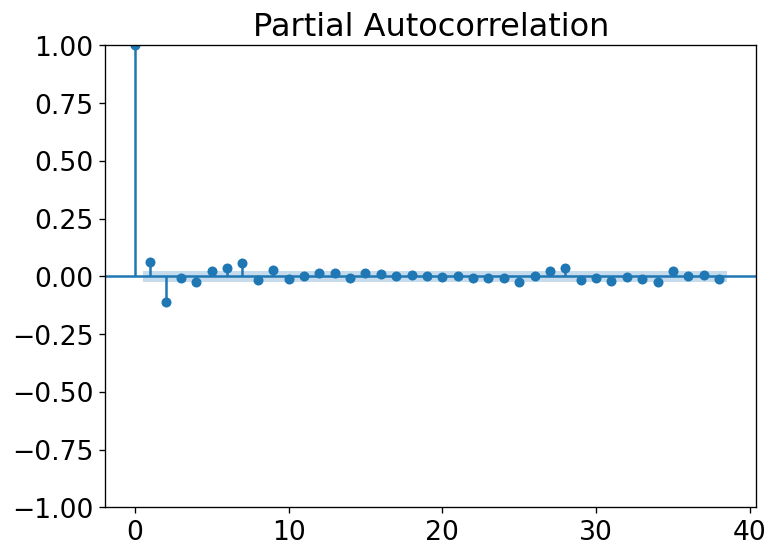

In [288]:
#Finding the p value
from statsmodels.graphics.tsaplots import plot_pacf

plt.rcParams.update({'figure.figsize':(7, 5), 'figure.dpi':120})
plot_pacf(INR_dataset.RATE.diff().dropna(), method='ywm')
plt.show()

Here we can see that the first lag is most significant than any other lags in the graph.
Hence p = 1.

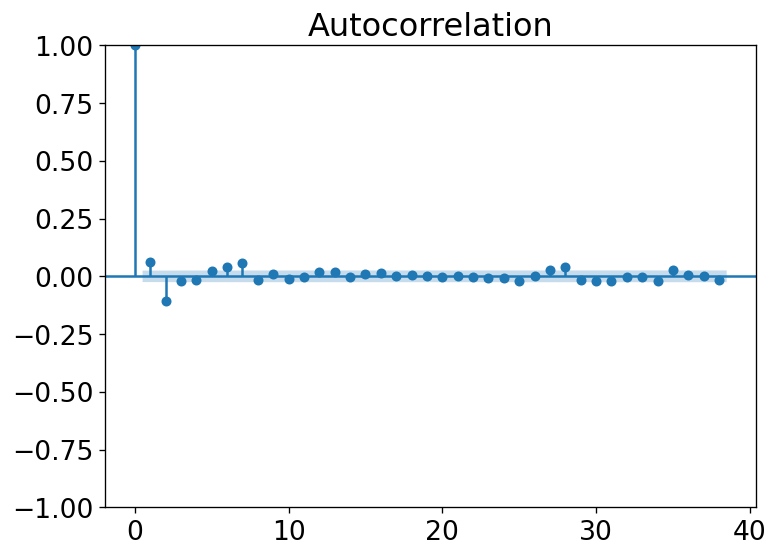

In [289]:
# Finding the q value

plot_acf(INR_dataset.RATE.diff().dropna())
plt.show()

Here we can see that only 1 of the lag is out of significant limit.
Hence q = 1.

In [290]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(INR_dataset['RATE'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(dis=-1)
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               RATE   No. Observations:                 6208
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                1562.635
Date:                            Wed, 05 Jul 2023   AIC                          -3115.270
Time:                                    19:02:39   BIC                          -3081.612
Sample:                                         0   HQIC                         -3103.600
                                           - 6208                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6534      0.041    -15.903      0.000      -0.734      -0.573
ma.L1          0.7370      0.037   

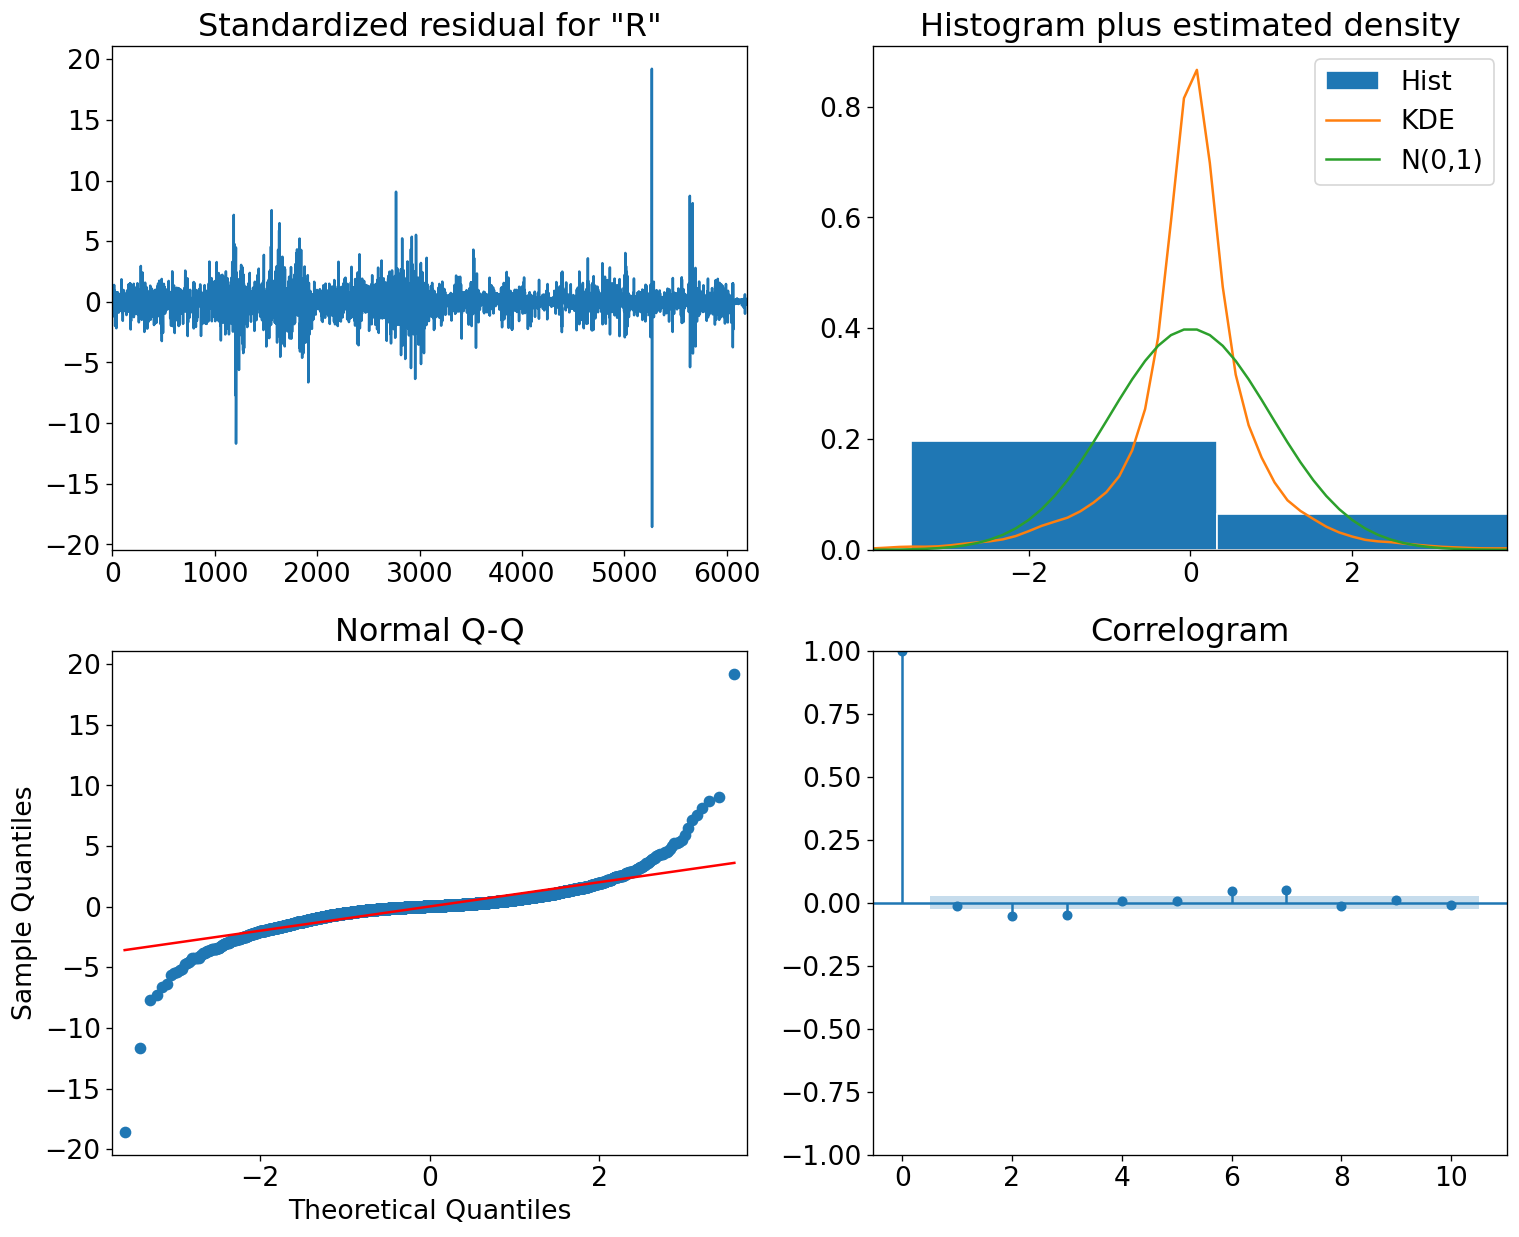

In [291]:
model.plot_diagnostics(figsize=(15,12))
plt.show()

In [292]:
INR_dataset = df_INR
INR_dataset.head()

,DATE,RATE,month,year,day,day_of_week
0,2016-12-31,67.9669,12,2016,31,5
1,2016-12-30,67.9728,12,2016,30,4
2,2016-12-29,67.9450,12,2016,29,3
3,2016-12-28,68.2289,12,2016,28,2
4,2016-12-27,67.9965,12,2016,27,1


In [293]:
INR_dataset = INR_dataset.reset_index()

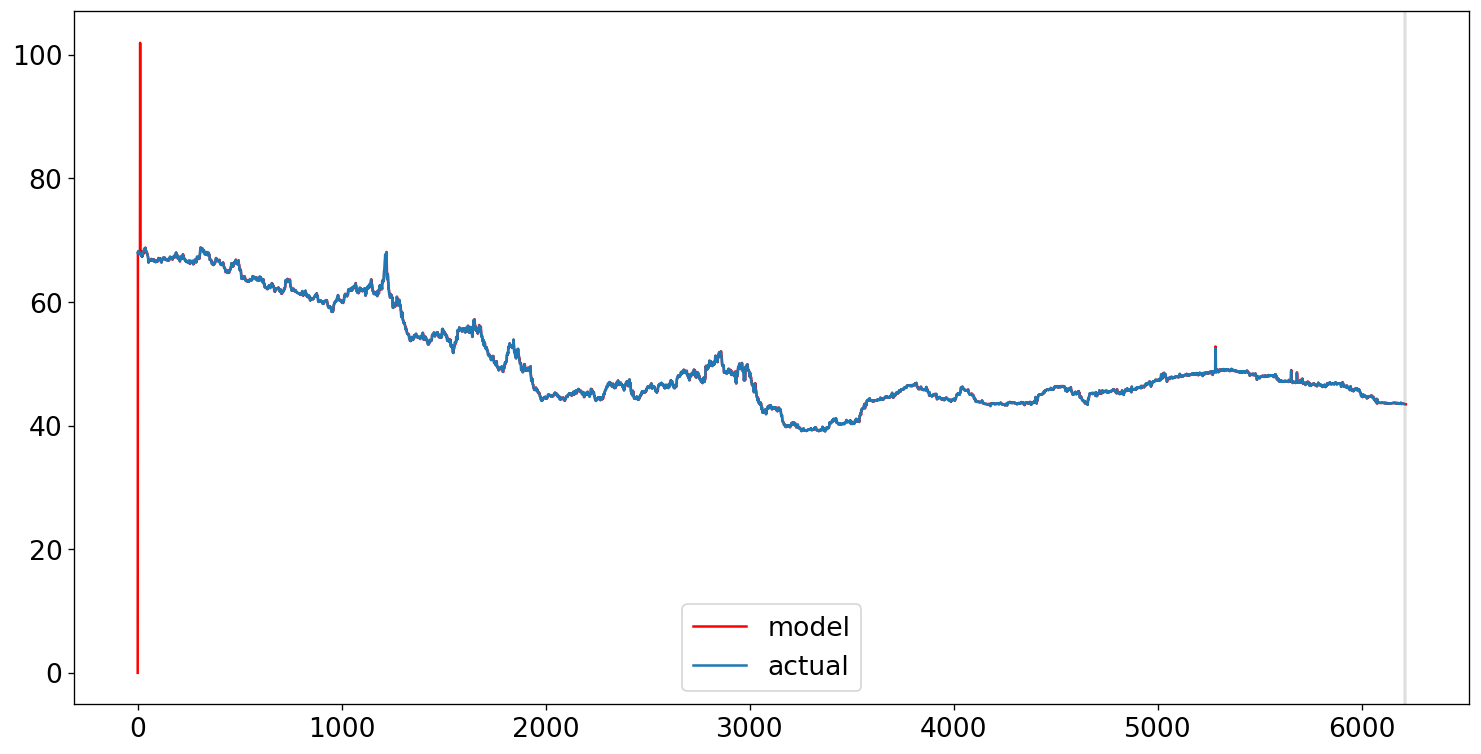

In [294]:
forecast = model.predict(start=0, end=INR_dataset.shape[0] + 8)

plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(INR_dataset.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(INR_dataset['RATE'], label='actual')
plt.legend()
plt.show()

In [295]:
#divide into train and validation set to calculate R-squared score and mean absolute percentage error 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

train = INR_dataset[:int(0.85*(len(INR_dataset)))]
test = INR_dataset[int(0.85*(len(INR_dataset))):]

start=len(train)
end=len(train)+len(test)-1
predictions = model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['RATE'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['RATE'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['RATE'], predictions)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test['RATE'], predictions))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['RATE'])
                                                               /np.abs(test['RATE']))*100 
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
0,0.984989,0.079434,0.045553,0.213432,NaN


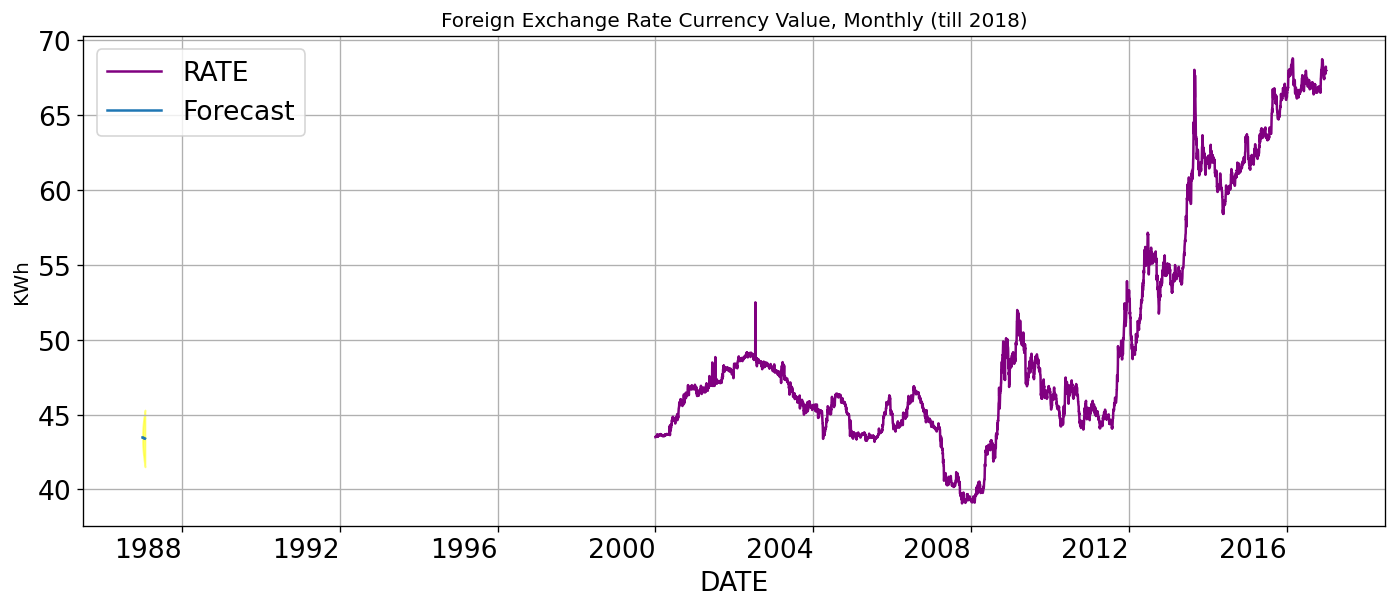

In [296]:
#Forecasting 2 years ahead
forecast_values = model.get_forecast(steps = 24)

#Confidence intervals of the forecasted values
forecast_ci = forecast_values.conf_int()

#Plot the data
ax = INR_dataset.plot(x='DATE', y='RATE', figsize = (14, 6), legend = True, color='purple')

#Plot the forecasted values 
forecast_values.predicted_mean.plot(ax=ax, label='Forecast', figsize = (14, 6), grid=True)

#Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color='yellow', alpha = .5)
plt.title('Foreign Exchange Rate Currency Value, Monthly (till 2018)', size = 12)
plt.ylabel('KWh', size=12)
plt.legend(loc='upper left')
ax.axes.get_xaxis().set_visible(True)

plt.show()

Conclusion: From all the models I have tried the XGB regression was the best with R2 score around 93 none of the other models have score greater than 90 the SARIMA also have the score of 81 only.